# Introduction
I've noticed that the term machine learning has become increasingly synonymous with deep learning (DL), artificial intelligence (AI) and neural networks (NNs). For example, [posts on the machine learning subreddit almost exclusively relate to neural network based approaches](https://www.reddit.com/r/MachineLearning/comments/6mloim/discussion_is_this_rmachinelearning_or/?st=j50yusg2&sh=68bba8ff) (and [great non-DL posts are not recognised sufficiently for their greatness](https://www.reddit.com/r/MachineLearning/comments/6a94oi/p_unsupervised_machine_learning_explained_with)). So it's time to get on board the hype train! Next stop, Keras! This post is actually relatively basic; we won't convert photos of horses to photos of zebras, we won't create jazz music. In fact, we won't do anything interesting. We'll just construct a simple Keras model to do basic predictions and illustrate some good practices along the way.

Tensor Flow (TF), Theano, Torch are among the most common deep learning libraries. The differences between each library has been discussed [elsewhere](https://deeplearning4j.org/compare-dl4j-torch7-pylearn). Basically, it comes down to the language in which it was written (i.e. Python, C++, etc.) and the level of abstraction.  Essentially, you want to balance flexibility (customised networks) with readability/interpretation. That's where Keras comes in. 

Having settled on Keras, We want to build a simple NN.You can refer to [this post](http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/) from the popular [machinelearningmastery website](http://machinelearningmastery.com/).This website is actually quite an extensive and powerful resource on machine learning. The range of topics covered is extremely impressive. Unfortunately, there's a danger of quantity superseding quality (I ensure quality by posting every 3 months). And that's possibly the case with [its Keras tutorial](http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/), as it overlooks fundamental steps in any deep learning model construction (specifically, normalising/scaling the data and splitting the data into separate training, validation and test sets).





# 1.Model Construction Basics

Here we are going to use the Premium Upgrade Sample Dataset which you can access from the Box folder. With just 10000 rows, it's a small dataset, especially in the context of deep learning. But its size will mean that we don't need to worry about things like [batch-size](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network), [CPUs vs GPUs](https://medium.com/@erikhallstrm/hello-world-tensorflow-649b15aed18c) and other computational concerns associated with complex NNs.

## Load in the dataset directly from your local directories. 

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

# load premium upgrade dataset
df = pd.read_table('Churn_Modelling.csv', sep = '|', error_bad_lines=False)


2.e Standard Scaling the Treated Data

Now the data needs to be scaled and/or normalised. Scaling/normalising the data traditionally involves linear transformation to force all values within a specific interval (e.g. between 0 and 1), while standardising typically transforms the inputs to have the mean centred on zero with unit variance. Either way, no input feature dominates the model and this forces consistent weights. For example, 5000 x 0.0002 = 2 x 0.5, so that weights differ by several orders of magnitude, which could inhibit backpropagation.

Scaling/normalising is easy; we can just employ some tools from scikit-learn. Note that you should scale/normalise the training and test sets separately. 

In [242]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
X2=scaler.transform(df)

In [243]:
from sklearn import cross_validation
validation_size = 0.3
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X2, Y, test_size=validation_size, random_state=seed)

# 3. Lets Develop our First Keras Model 

The data for the model is ready. Now we just need a model. We'll start with a simple single layer fully connected neural network (this is generally not considered deep learning, where deepness is determined by the number of hidden layers). This is pleasingly simple to build in Keras. We just initialise our model and then sequentially add layers (see GIF below). We also need to decide how to assess the accuracy of the model (called loss). As it's a classification problem, [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) is the most appropriate measure of error (a regression task might use mean squared error). A full list of the error functions available with Keras can be found [here](https://keras.io/losses/).

![Stack more layers with Keras](https://dashee87.github.io/images/keras_layer_stacking.gif)

In [253]:
np.random.seed(seed)
nn = Sequential() # create model
nn.add(Dense(5, input_dim=9, activation='relu')) # hidden layer
nn.add(Dense(1, activation='sigmoid')) # output layer
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We don't explicitly create the input layer. Instead, we specify the number of neurons (or features) that feed into the first hidden layer. We also don't need to worry about the input dimensions for subsequent layers, as the neurons in the previous layer form the input for the next layer. We've opted for 9 neurons in the hidden layer for now.

The `activation` argument decides (unsurprisingly) the activation function for that layer. A less circular explanation is that activation functions combine the neuron inputs to produce an output. For example, a step function would mean a neuron fires (has a non-zero value) if the input values exceed a certain threshold. Various activation functions are described [here](https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons). Finally, you'll notice the optimizer argument is set to `adam`. `adam` stands for Adaptive Moment Estimation; it's how the model tunes its parameters in order to minimise the training error (a good overview of deep learning optimization functions can be found [here](http://ruder.io/optimizing-gradient-descent/)).

Keras allows you to observe the current state of your model at particular points in time, known as [callbacks](https://keras.io/callbacks/). One such callback is a [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint), which we will deploy to write the model parameters to a file. This will allow us to track the improvements in the predictive accuracy of the model on the test set over epochs. Note that this step is optional and can be safely ignored if you're not interested in the performance of your model during intermediate steps. In fact, it's quite a bad habit to compare model characteristics on the test set. Ideally, it should only be deployed at the very end.

3.a Callbacks

In [254]:
from keras.callbacks import ModelCheckpoint
# specify filepath- this will write a new file for each epoch with the epoch number contained within the filename
filepath="nn_weights-{epoch:02d}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                                             save_weights_only=False, save_best_only=False, mode='max')

We're ready to fit our neural network to the training dataset. We pass the model the input and output as separate arguments. We may also specify the batch size and number of epochs (model iterations). More information on the `fit` method can be found [here](https://keras.io/models/model/#fit).

In [255]:
# verbose=0 suppresses the file writing message
# note that the fit method expects a list of callbacks
nn_fitted = nn.fit(X_train, Y_train, epochs=100, verbose=0, batch_size=32,
                                     callbacks=[checkpoint], initial_epoch=0)
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 5)                 50        
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 6         
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


From the above summary we can understand that for dense_1 layer , number of params is 50. This is obtained as : 9 (input values) multipled by  5(neurons in the first layer) + 5 (bias values)
For dense_2 layer, number of params is 6. This is obtained as : 5 (input values) multiplied by  1 (neurons in the second layer) + 1 (bias values for neurons in the second layer). Hence, Gives us a total of 56  trainable parameters.

And if you want to assess the performance of your model on the test dataset, use the [evaluate method](https://keras.io/models/model/#evaluate).

In [256]:
# [loss, accuracy]
my_first_nn.evaluate(X_validation, Y_validation, verbose=0)

[0.051256561567385991, 0.98966666682561244]

The values in the list are the model loss and accuracy, respectively. If you're interested in how the training error changed over time, you can call `my_first_nn_fitted.history`.

In [257]:
# training loss and accuracy over the first five epochs
[nn_fitted.history['loss'][0:5], my_first_nn_fitted.history['acc'][0:5]]

[[0.49006039292471748,
  0.13489247652462549,
  0.080188057537589758,
  0.07200541259348392,
  0.070326684238655221],
 [0.85685714285714287,
  0.98785714285714288,
  0.98785714285714288,
  0.98785714285714288,
  0.98785714285714288]]

You may also want to visualise how the model performed on the test set over time. Remember that we saved the model weights to a file at each epoch.  This means we can reproduce each intermediate model by loading the weights into an appropriately constructed (i.e. same number of layers/neurons) neural network.

3.b Model Performance (Visualization)

In [258]:
temp_test_model = Sequential() # create model
temp_test_model.add(Dense(5, input_dim=9, activation='relu')) # hidden layer
temp_test_model.add(Dense(1, activation='sigmoid')) # output layer
temp_test_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
test_over_time = []

for i in range(len(nn_fitted.history['acc'])):
    i=i+1
    temp_test_model.load_weights("nn_weights-%02d.hdf5" % i)
    scores = temp_test_model.evaluate(X_validation, Y_validation, verbose=0)
    # 0 is loss; 1 is accuracy
    test_over_time.append(scores)
y_pred = temp_test_model.predict_proba(X_validation)
    

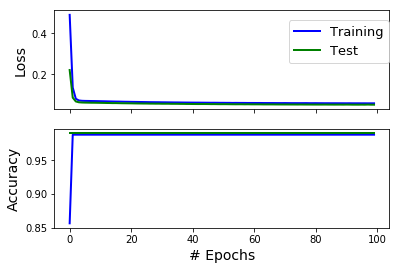

In [259]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(nn_fitted.history['loss'])), _nn_fitted.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(np.array(test_over_time)[:,0])), np.array(test_over_time)[:,0], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(nn_fitted.history['acc'])), nn_fitted.history['acc'],linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(np.array(test_over_time)[:,1])), np.array(test_over_time)[:,1], linestyle='-', color='green',label='Test', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
#ax1.set_yscale('log')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.show()

Now ,This method will work great if we have balanced datasets. However as our datasets have very low target percentage its better to check the model performance using AUC method. Th code below gives the ROC of the baseline model.

3.c ROC graph

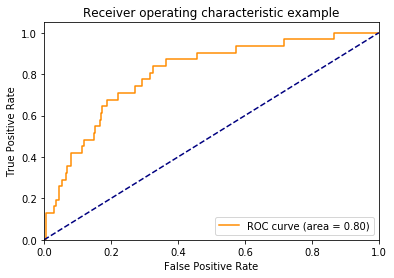

In [260]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1, tpr1, _ = roc_curve(Y_validation, y_pred)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 4.Your Turn!

## Hands On- Cheat Sheet 


Before we start here is your cheat sheet. Look at the different features, optimizers, hyperparameters or change the number of layers, neuron density and compare your results.

### keras core layers
##### Dense
```python
from keras.layers.core import Dense

Dense(units, activation=None, use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', 
      kernel_regularizer=None, bias_regularizer=None, 
      activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
```
* `units`: int > 0.

* `kernel_initializer`: Initializer for the kernel weights matrix.

* `bias_initializer`: Initializer for the bias vector.

* `activation`: name of activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: `a(x) = x`).

* `weights`: list of Numpy arrays to set as initial weights. The list should have 2 elements, of shape (input_dim, output_dim) and (output_dim,) for weights and biases respectively.

* `kernel_regularizer`: Regulariser function (eg. L1 or L2 regularization), applied to the `kernel` weights matrix.

* `bias_regularizer`: Regulariser function applied to the bias vector.

* `activity_regularizer`: Regularizer function applied to the output of the layer (its "activation").

* `kernel_constraint`: Constraint function applied to the main weights matrix.

* `bias_constraint`: Constraint function applied to the bias.

* `use_bias`: whether to include a bias (i.e. make the layer affine rather than linear).
**Supported Core layers** : [https://keras.io/layers/core/]


### Initializers

Weight initialization can critically affect the speed at which a neural network is able to learn. Under certain circumstances, a poor initialization of weights can prevent a neural network from learning anything.

For further details, please refer to this super interesting article from NVIDIA DIGITS: [Weights Initialisers](https://github.com/NVIDIA/DIGITS/blob/master/examples/weight-init/README.md)

**Supported Initializers**: [https://keras.io/initializers/]

### Activation
**Supported Activations** : [https://keras.io/activations/]

**Advanced Activations**: [https://keras.io/layers/advanced-activations/]

### Optimizer

If you need to, you can further configure your optimizer. A core principle of Keras is to make things reasonably simple, while allowing the user to be fully in control when they need to (the ultimate control being the easy extensibility of the source code).
**Supported Optimizers** : [https://keras.io/optimizers/]

### Loss

**Supported Loss** : [https://keras.io/losses/]

### Regularization

Regularizers allow to apply penalties on layer parameters or layer activity during optimization. These penalties are incorporated in the loss function that the network optimizes.

**Supported Regularization** : [https://keras.io/regularizers/]

### Avoid Overfitting
Applies Dropout to the input.
Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

**Supported Dropout** : [https://keras.io/layers/core/#dropout]

### Generalizing our models
#### Early Stopping
Remember, a good model is one that generalises well to unseen data. As such, reductions in the training error are only beneficial if they coincide with improvements in the test accuracy. Ideally, we'd stop training the model when it's no longer improving the test accuracy.As well as for preventing overfitting, one obvious advantage of early stopping is that it allows the model to stop early. You won't find that kind of insight on [machinelearningmastery](https://machinelearningmastery.com/)!!! While it may not appear hugely beneficial for our small simplified model, in the world of deep learning and driverless cars, this could save you some time. Of course, early stopping raises the prospect of premature stopping (i.e. terminating the training phase at a sub-optimal configuration).
**Supported Early Stopping ** : [https://en.wikipedia.org/wiki/Early_stopping]

#### Hyperparameter Tuning (& Cross-Validation)
Hopefully, you've realised that less is sometimes more. Iterating over fewer epochs can actually improve the predictive power of the model. How about the number of nodes in the single hidden layer? Surely, we should just cramming them in there. Right? Well, this is known as hyperparamater tuning/optimisation- as opposed to parameter tuning, which is changing the model weights during the training phase. We can run multiple models with varying number of nodes (which we specify) and accept the version that performs best on the validation set. This is known as grid search (we're searching over a grid of values... yet more insightful insights you won't find anywhere else). Note that the process is similar if you want to tune other model hyperparameters (e.g. learning rate, batch size, activation functions, etc.).

## Tips to Make your Journey in Neural Network Modelling Easy

1.Diagnostics

A quick way to get insight into the learning behavior of your model is to evaluate it on the training and a validation dataset each epoch, and plot the results.

If training is much better than the validation set, you are probably overfitting and you can use techniques like regularization.
If training and validation are both low, you are probably underfitting and you can probably increase the capacity of your network and train more or longer.
If there is an inflection point when training goes above the validation, you might be able to use early stopping.

2.Optimization and Loss

I have found that newer/popular methods can converge a lot faster and give a quick idea of the capability of a given network topology, for example:
ADAM
RMSprop
You can also explore other optimization algorithms such as the more traditional (Levenberg-Marquardt) and the less so (genetic algorithms). Other methods can offer good starting places for SGD and friends to refine.

The loss function to be optimized might be tightly related to the problem you are trying to solve.
 
3.Learning Rates

Experiment with very large and very small learning rates.
Grid search common learning rate values from the literature and see how far you can push the network.
Try a learning rate that decreases over epochs.
Try a learning rate that drops every fixed number of epochs by a percentage.
Try adding a momentum term then grid search learning rate and momentum together.
Tips For Using Dropout
The original paper on Dropout provides experimental results on a suite of standard machine learning problems. As a result they provide a number of useful heuristics to consider when using dropout in practice.

4.Activation Functions

Before that it was sigmoid and tanh, then a softmax, linear or sigmoid on the output layer. I don’t recommend trying more than that unless you know what you’re doing.For example, switch your sigmoid for binary classification to linear for a regression problem, then post-process your outputs. This may also require changing the loss function to something more appropriate.

5.Network Topology

You must discover a good configuration for your problem. Experiment.

Try one hidden layer with a lot of neurons (wide).
Try a deep network with few neurons per layer (deep).
Try combinations of the above.
Try architectures from recent papers on problems similar to yours.
Try topology patterns (fan out then in) and rules of thumb from books and papers (see links below).
It’s hard. Larger networks have a greater representational capability, and maybe you need it.

More layers offer more opportunity for hierarchical re-composition of abstract features learned from the data. Maybe you need that.Later networks need more training, both in epochs and in learning rate. Adjust accordingly.

6.Batches and Epochs

Small batch sizes with large epoch size and a large number of training epochs are common in modern deep learning implementations.

This may or may not hold with your problem. Gather evidence and see.

Try batch size equal to training data size, memory depending (batch learning).
Try a batch size of one (online learning).
Try a grid search of different mini-batch sizes (8, 16, 32, …).
Try training for a few epochs and for a heck of a lot of epochs.
Consider a near infinite number of epochs and setup check-pointing to capture the best performing model seen so far

7.Drop Out

Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.
Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.


## Hands On - Keras Fully Connected

3000/3000 [==============================] - 0s 108us/step
Accuracy:  98.9666666826
loss: 5.10767024408


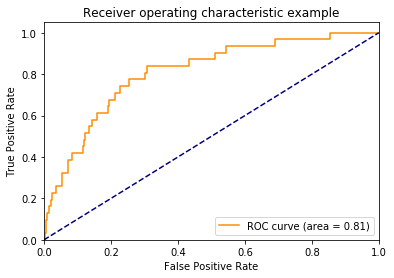

In [261]:
#Things you can play with.....

#1.Increase no of layers
#2.Change the no of neurons in the layers
#3.Change the optimizers-{SGD, Adam, RMSprop}
#4.Add regularizer
#5.Add Dropout layer
#6.Change the No of epochs

Model = Sequential()
Model.add(Dense(16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))
Model.add((Dense(8, kernel_initializer = 'uniform', activation = 'relu')))
Model.add(Dense(1, kernel_initializer  = 'uniform', activation = 'sigmoid'))
# Compiling Neural Network
Model.compile(optimizer = "adam" , loss = 'binary_crossentropy', metrics = ['accuracy'])

#fitting the neural Network
#(you can change the verbose=1 to see the complete output or else keep it to 0)
history=Model.fit(X_train, Y_train,  batch_size=32, epochs = 100, verbose=0, validation_split=0.2,  shuffle=True)
score = Model.evaluate(X_validation, Y_validation, verbose=1)
print('Accuracy: ', score[1]*100)
print( 'loss:', score[0]*100)
y_pred = Model.predict_proba(X_validation)
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr1, tpr1, _ = roc_curve(Y_validation, y_pred)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Summary

This post was much more detailed (and wordy) than I had initially planned. Who knew there were so many ways to mess up a neural net? If you intend to actually gain some meaningful insights from your model (could happen...), then here are my top tips:

* Construct sensible training/validation/test splits
* Scale/Normalise/Standardise your input data
* Include early stopping to prevent overfitting ([dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) could also work here)
* If conducting hyperparameter optimisation, select model with best performance on the validation set from repeated cross-validation
* Evaluate model on test set

Thanks for reading!!! All the best!
